# Імпорт бібліотек

In [ ]:
import numpy as np
import pandas as pd 
import os
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

for dirname, _, filenames in os.walk('../input/tabular-playground-series-may-2021'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Попередні налаштування для навчання і прогнозування

In [ ]:
ID_cols='id'
Target = 'target'
Submission_cols = ['Class_1', 'Class_2', 'Class_3', 'Class4']

Unuse_columns_for_train = [ID_cols,]
Train_reject_items = Unuse_columns_for_train + [Target]

# Читання з фалйу і вивід інформації

In [ ]:
data_train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv',delimiter=",", header=0)
data_test=pd.read_csv('../input/tabular-playground-series-may-2021/test.csv',delimiter=",", header=0)

X=pd.DataFrame(data_train).drop(columns=Train_reject_items,axis=1)

y=pd.Series(data_train[Target])

print('----------------------------------------------------------------')
print('X розмірність: (%i,%i)' %X.shape)
print('----------------------------------------------------------------')
print('y розмірність: (%i,)' %y.shape)
print('----------------------------------------------------------------')
print(y.value_counts())
print('----------------------------------------------------------------')
print()
print('dataset:csv "сирі" дані')
display(data_train.head())
print('X: Train dataset')
X.join(y).head()

# Перевірка на Missing Values

In [ ]:
data_train.isnull().sum()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)

In [ ]:
X.head()

# Dimention compression використовуючи RFE

In [ ]:
#Задання параметрів
n_estimators=100
n_features_to_select=20
step=.05

In [ ]:
def dimension_compression(X, y):
    start = time.time()
    selector = RFE(RandomForestClassifier(n_estimators=n_estimators, random_state=1),
               n_features_to_select=n_features_to_select,
               step=step)
    selector.fit(X,y)
    X_columns =  X.columns.values
    
    X_fin = X.loc[:, X_columns[selector.support_]]
    
    duration = time.time() - start
    #print(duration,'s')
    
    print('Час виконання:',duration,'s', 'X_fin розмірність:(%i,%i)' % X_fin.shape)
    display(X_fin.head())
    return X_fin, selector
    
X_fin, selector = dimension_compression(X, y)

In [ ]:
print('-----------------------------------')
print('X_fin розмірність: (%i,%i)' %X_fin.shape)
print('-----------------------------------')
print(y.value_counts())
print('--------------------------------------------------')
print('--------------------------------------------------')
print('y розмірність: (%i,)' %y.shape)
print('--------------------------------------------------')

In [ ]:
scores={}
def Training(Class_name,param, ev_score,tag):
    start = time.time()
    gs = GridSearchCV(estimator=Class_name,
                     param_grid = param,
                     scoring=ev_score,
                     cv=5,
                     return_train_score=False)
    model = gs.fit(X,y)
    
    print('Затрачений час', time.time()-start)
    scores[(Class_name,'train')] = accuracy_score(y_train, gs.predict(X_train))
    scores[(Class_name,'test')] = accuracy_score(y_test, gs.predict(X_test))
    return model

In [ ]:
Train=Training(Pipeline([('scl',StandardScaler()),('est',LGBMClassifier())]), {'est__learning_rate': [0.1], 'est__max_depth': [50], 'est__n_estimators': [100], 'est__num_leaves': [31]}, 'accuracy', 'selected')

In [ ]:
ID_s = data_test.iloc[:,[0]]
X_s = data_test.drop(Unuse_columns_for_train, axis=1)

print('-----------------------------------')
print('Початкова тест розмірність: (%i, %i)' %data_test.shape)
print('X_s розмірність: (%i, %i)' %X_s.shape)
print('-----------------------------------')
print(X_s.dtypes)
ID_s.join(X_s).head()

In [ ]:
# prediction
y_pred = Train.predict_proba(X_s)
print(len(y_pred))

In [ ]:
id_df=pd.DataFrame(data=ID_s,columns=[ID_cols])

submission_column_list =  ['Class_1','Class_2', 'Class_3', 'Class_4']
result_df = pd.DataFrame(data=y_pred,columns=submission_column_list)
submit_df = pd.concat([id_df, result_df], axis=1)
submit_df.head()

In [ ]:
submit_df.to_csv('./sample_submission.csv', index=False)

In [ ]:
result = pd.read_csv('./sample_submission.csv',delimiter=",", header=0)
result

# Результат Submition

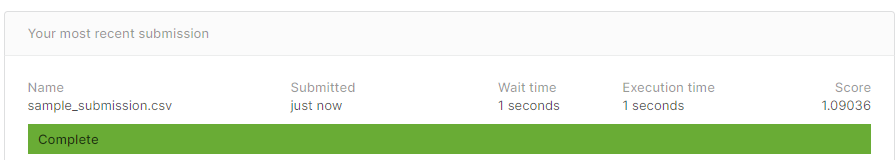